# Import required LIbraries and set path

In [1]:
import sys, os, yaml
sys.path.append(os.path.abspath('/spark-data'))

# Import Spark session and create the session according to user configurations

In [2]:
#Importing Spark Session
from utils.create_spark_session import load_config, create_spark_session

config = load_config("/spark-data/config/spark_session_config.yaml")
spark = create_spark_session(config=config)

:: loading settings :: url = jar:file:/opt/bitnami/spark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.postgresql#postgresql added as a dependency
com.crealytics#spark-excel_2.12 added as a dependency
org.apache.hadoop#hadoop-aws added as a dependency
net.snowflake#snowflake-jdbc added as a dependency
net.snowflake#spark-snowflake_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ee070b61-8575-4c2d-b53d-f894538fc485;1.0
	confs: [default]
	found org.postgresql#postgresql;42.2.20 in central
	found org.checkerframework#checker-qual;3.5.0 in central
	found com.crealytics#spark-excel_2.12;3.4.1_0.19.0 in central
	found org.apache.poi#poi;5.2.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.commons#commons-collections4;4.4 in central
	found org.apache.commons#commons-math3;3.6.1 in central
	found com.zaxxer#SparseBitSet;1.2 in central
	found org.apache.poi#poi-ooxml;5.2.3 in central
	found org.apache.poi#poi-ooxml-lit

# Load the tables from source AWS S3 According user config into spark dataframes

In [3]:
from Data_Extraction.data_extract_from_aws import load_files_from_s3

# Load the configuration from the YAML file
with open('/spark-data/config/data_extraction_aws.yaml', 'r') as file:
    config = yaml.safe_load(file)

aws_config = config.get('s3_config', {})


#Loading Configuration
bucket_name = aws_config.get('bucket_name', {})
folder_path = aws_config.get('folder_path', {})
file_name = aws_config.get('file_name', {})
region_name = aws_config.get('region_name', {})

In [4]:
dataframes = load_files_from_s3(spark, bucket_name=bucket_name, folder_name=folder_path)

2024-11-01 09:49:35,977 - INFO - Starting to load files from bucket: pyspark-etl-data-extraction-service, folder: PySpark-Data, file: None
2024-11-01 09:49:36,039 - INFO - Found credentials in shared credentials file: ~/.aws/credentials
2024-11-01 09:49:36,976 - INFO - Found 2 files in folder PySpark-Data in bucket pyspark-etl-data-extraction-service.
2024-11-01 09:49:36,980 - INFO - Processing file: PySpark-Data/data.json
24/11/01 09:49:38 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
2024-11-01 09:49:59,251 - INFO - Loaded nested JSON field 'order_item' from file 'PySpark-Data/data.json' into dataframe 'df_data_order_item' with 10000 rows.
2024-11-01 09:50:04,338 - INFO - Loaded nested JSON field 'review' from file 'PySpark-Data/data.json' into dataframe 'df_data_review' with 10000 rows.
2024-11-01 09:50:04,339 - INFO - Processing file: PySpark-Data/data.xlsx
2024-11-01 09:50:17,022 - INFO - Successfully l

# Apply Data Cleaning on all dataframe

In [5]:
dataframes

{'df_data_order_item': DataFrame[order_id: bigint, order_item_id: bigint, price: bigint, product_id: bigint, quantity: bigint],
 'df_data_review': DataFrame[customer_id: bigint, product_id: bigint, rating: bigint, review_date: string, review_id: bigint, review_text: string],
 'df_data_orders': DataFrame[order_id: double, customer_id: double, order_date: timestamp, total_amount: double, shipping_address: string, billing_address: string],
 'df_data_product': DataFrame[product_id: double, product_name: string, category: string, price: double, description: string, inventory: double],
 'df_data_customer': DataFrame[customer_id: double, first_name: string, last_name: string, email: string, phone_number: string, city: string, state: string, zip_code: double, birth_date: timestamp]}

In [6]:
from Data_Cleaning.data_cleaning import data_cleaning_pipeline

In [7]:
# Load the configuration from the YAML file
with open('/spark-data/config/cleaning_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

cleaning_config = config.get('cleaning', {})
dataframes_config = config.get('dataframes', {})

In [8]:
# Map DataFrame names from the config to actual DataFrames from the 'dfs' dictionary
dataframes = {
    df_name: dataframes.get(f"df_data_{df_name}") for df_name in dataframes_config.keys()
}

In [9]:
cleaned_dataframes = data_cleaning_pipeline(dataframes, cleaning_config, spark)

2024-11-01 09:50:39,519 - INFO - Analyzing DataFrame: customer
2024-11-01 09:51:25,471 - INFO - Analyzing DataFrame: orders                    
2024-11-01 09:52:09,535 - INFO - Analyzing DataFrame: product
2024-11-01 09:52:42,078 - INFO - Analyzing DataFrame: order_item
2024-11-01 09:53:18,578 - INFO - Analyzing DataFrame: review                    
2024-11-01 09:54:00,151 - INFO - Analysis DataFrame created successfully.       
2024-11-01 09:54:00,153 - INFO - Starting cleaning process for customer
2024-11-01 09:54:00,154 - INFO - Applying remove_duplicates with params {'columns': ['customer_id']}
2024-11-01 09:54:00,160 - INFO - Successfully removed duplicate rows based on columns: ['customer_id'].
2024-11-01 09:54:03,629 - INFO - Applying remove_decimal with params {'columns': ['customer_id', 'zip_code']}
2024-11-01 09:54:03,655 - INFO - Successfully removed decimal values from column 'customer_id'.
2024-11-01 09:54:03,670 - INFO - Successfully removed decimal values from column 'zi

In [10]:
cleaned_dataframes

{'customer': DataFrame[customer_id: bigint, first_name: string, last_name: string, email: string, phone_number: string, city: string, state: string, zip_code: string, birth_date: date],
 'orders': DataFrame[order_id: bigint, customer_id: bigint, order_date: date, total_amount: bigint, shipping_address: string, billing_address: string],
 'product': DataFrame[product_id: bigint, product_name: string, category: string, price: double, description: string, inventory: int],
 'order_item': DataFrame[order_id: bigint, order_item_id: bigint, price: bigint, product_id: bigint, quantity: bigint],
 'review': DataFrame[customer_id: bigint, product_id: bigint, rating: bigint, review_date: date, review_id: bigint, review_text: string]}

# Data Transformation

### Get all the required user imports 

In [11]:
# Load the configuration from the Transformationa Config YAML file
with open('/spark-data/config/transformation_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

#Transformation Config
transformation_config = config.get('transformations', {})
dataframes_config = config.get('dataframes', {})



In [12]:
# Map DataFrame names from the config to actual DataFrames from the 'cleaned_dataframes' dictionary
cleaned_dataframes = {
    df_name: cleaned_dataframes.get(f"{df_name}") for df_name in dataframes_config.keys()
}

In [13]:
from Data_Transformation.transformation import data_transformation_pipeline

In [14]:
# Apply the transformation pipeline
transformed_dataframes = data_transformation_pipeline(cleaned_dataframes, transformation_config)

2024-11-01 10:00:30,717 - INFO - Starting transformation process for customer
2024-11-01 10:00:30,721 - INFO - Applying add_age_column with params {'birth_date_column': 'birth_date'}
2024-11-01 10:00:30,723 - INFO - Starting to add 'age' column based on the birth date column.
2024-11-01 10:00:30,724 - INFO - Column 'birth_date' found. Calculating age, handling 'Invalid Date' if present.
2024-11-01 10:00:30,759 - INFO - Age column added successfully.
2024-11-01 10:00:30,760 - INFO - Successfully applied add_age_column to customer
2024-11-01 10:00:30,761 - INFO - Completed transformation process for customer
2024-11-01 10:00:30,762 - INFO - Starting transformation process for orders
2024-11-01 10:00:30,763 - INFO - Applying add_state_columns with params {'shipping_col': 'shipping_address', 'billing_col': 'billing_address'}
2024-11-01 10:00:30,764 - INFO - Starting to add state columns based on the specified address columns.
2024-11-01 10:00:30,765 - INFO - Columns 'shipping_address' and 

In [15]:
transformed_dataframes

{'customer': DataFrame[customer_id: bigint, first_name: string, last_name: string, email: string, phone_number: string, city: string, state: string, zip_code: string, birth_date: date, age: bigint],
 'orders': DataFrame[order_id: bigint, customer_id: bigint, order_date: date, total_amount: bigint, shipping_address: string, billing_address: string, shipping_state: string, billing_state: string],
 'product': DataFrame[product_id: bigint, product_name: string, category: string, price: double, description: string, inventory: int],
 'order_item': DataFrame[order_id: bigint, order_item_id: bigint, price: bigint, product_id: bigint, quantity: bigint],
 'review': DataFrame[customer_id: bigint, product_id: bigint, rating: bigint, review_date: date, review_id: bigint, review_text: string]}

# Save Transformed Dataframes into postgreSQL

In [16]:
from utils.postgres_utils import save_dfs_to_postgres_upsert

In [17]:
# Load the configuration from the YAML file
with open('/spark-data/config/postgreSQL_loading_config.yaml', 'r') as file:
    config = yaml.safe_load(file)


#Loading Configuration
postgres_config = config.get('postgresql', {})
jdbc_url = postgres_config.get('jdbc_url')
properties = postgres_config.get('properties')
unique_keys = postgres_config.get('unique_keys')

dataframes_config = config.get('dataframes', {})



In [18]:
# Map DataFrame names from the config to actual DataFrames from the 'dfs' dictionary
dataframes = {
    df_name: transformed_dataframes.get(f"{df_name}") for df_name in dataframes_config.keys()
}

In [19]:
dataframes

{'customer': DataFrame[customer_id: bigint, first_name: string, last_name: string, email: string, phone_number: string, city: string, state: string, zip_code: string, birth_date: date, age: bigint],
 'orders': DataFrame[order_id: bigint, customer_id: bigint, order_date: date, total_amount: bigint, shipping_address: string, billing_address: string, shipping_state: string, billing_state: string],
 'product': DataFrame[product_id: bigint, product_name: string, category: string, price: double, description: string, inventory: int],
 'order_item': DataFrame[order_id: bigint, order_item_id: bigint, price: bigint, product_id: bigint, quantity: bigint],
 'review': DataFrame[customer_id: bigint, product_id: bigint, rating: bigint, review_date: date, review_id: bigint, review_text: string]}

In [20]:
save_dfs_to_postgres_upsert(spark,jdbc_url, properties, unique_key_columns=unique_keys, **dataframes)

2024-11-01 10:00:35,068 - INFO - DataFrame customer upserted into PostgreSQL.
2024-11-01 10:00:37,659 - INFO - DataFrame orders upserted into PostgreSQL.
2024-11-01 10:00:40,203 - INFO - DataFrame product upserted into PostgreSQL.
2024-11-01 10:00:45,316 - INFO - DataFrame order_item upserted into PostgreSQL. 
2024-11-01 10:00:52,449 - INFO - DataFrame review upserted into PostgreSQL.     


In [21]:
dataframes

{'customer': DataFrame[customer_id: bigint, first_name: string, last_name: string, email: string, phone_number: string, city: string, state: string, zip_code: string, birth_date: date, age: bigint],
 'orders': DataFrame[order_id: bigint, customer_id: bigint, order_date: date, total_amount: bigint, shipping_address: string, billing_address: string, shipping_state: string, billing_state: string],
 'product': DataFrame[product_id: bigint, product_name: string, category: string, price: double, description: string, inventory: int],
 'order_item': DataFrame[order_id: bigint, order_item_id: bigint, price: bigint, product_id: bigint, quantity: bigint],
 'review': DataFrame[customer_id: bigint, product_id: bigint, rating: bigint, review_date: date, review_id: bigint, review_text: string]}

# Saved Transformed Dataframe or table into Snowflake Table with Upsert

In [22]:
import yaml

# Load the configuration from the Transformationa Config YAML file
with open('/spark-data/config/data_loading_snowflake_config.yaml', 'r') as file:
    config = yaml.safe_load(file)

#Transformation Config
snowflake_config = config.get('snowflake', {})
dataframes_config = config.get('dataframes', {})
unique_keys_config = config.get('unique_keys', {})


In [23]:
from utils.data_loading_snowflake import process_dataframes

# Save Data on SnowFlake

In [24]:
process_dataframes(spark, snowflake_config, dataframes, unique_keys_config)

2024-11-01 10:00:56,803 - INFO - Check if table: customer is exists or not in snowflake
2024-11-01 10:00:56,806 - INFO - Checking if table exist or not in snowflake
2024-11-01 10:00:59,331 - INFO - Got success result to check if exist or not!
2024-11-01 10:01:01,055 - INFO - Table customer exists in snowflake so perform upsert for customer
2024-11-01 10:01:01,056 - INFO - Starting upserting the data on: customer
2024-11-01 10:01:01,057 - INFO - Creating temprory table for upserting the data on: customer
2024-11-01 10:01:08,345 - INFO - Sucessfully created temperory table into snowflake customer_TEMP
2024-11-01 10:01:08,347 - INFO - Start Merge Operation, Upsering the data!
2024-11-01 10:01:12,472 - INFO - Successfully executed merge query.
2024-11-01 10:01:12,570 - INFO - Drop temperory table after upserting into main table.
2024-11-01 10:01:13,048 - INFO - Temp table CUSTOMER_TEMP dropped successfully.
2024-11-01 10:01:13,138 - INFO - Sucessfully Upserted the dataframe into snowflake 

# Load all the tables from PostgreSQL into spark dataframes

In [25]:
from utils.postgres_utils import load_all_tables

In [26]:
dataframes = load_all_tables(spark, jdbc_url, properties)

2024-11-01 10:02:07,887 - INFO - Fetching table names from PostgreSQL.
2024-11-01 10:02:08,150 - INFO - Loading table review into DataFrame.
2024-11-01 10:02:08,318 - INFO - Loading table product into DataFrame.
2024-11-01 10:02:08,366 - INFO - Loading table order_item into DataFrame.
2024-11-01 10:02:08,414 - INFO - Loading table customer into DataFrame.
2024-11-01 10:02:08,465 - INFO - Loading table orders into DataFrame.
2024-11-01 10:02:08,517 - INFO - Successfully loaded all tables into DataFrames.


In [27]:
dataframes

{'review': DataFrame[customer_id: bigint, product_id: bigint, rating: int, review_date: date, review_id: bigint, review_text: string],
 'product': DataFrame[product_id: bigint, product_name: string, category: string, price: double, description: string, inventory: int],
 'order_item': DataFrame[order_id: bigint, order_item_id: bigint, price: int, product_id: bigint, quantity: int],
 'customer': DataFrame[customer_id: bigint, first_name: string, last_name: string, email: string, phone_number: string, city: string, state: string, zip_code: string, birth_date: date, age: bigint],
 'orders': DataFrame[order_id: bigint, customer_id: bigint, order_date: date, total_amount: bigint, shipping_address: string, billing_address: string, shipping_state: string, billing_state: string]}

In [28]:
review = dataframes["review"]
product = dataframes["product"]
order_item = dataframes["order_item"]
customer = dataframes["customer"]
orders = dataframes["orders"]

# Insights and Visulizaition 

### Top 10 Selling Products

In [29]:
from Data_Visualization.visualization import get_top_selling_products

2024-11-01 10:02:08,917 - INFO - Starting the process to get top selling products.
2024-11-01 10:02:08,919 - INFO - Joining order_item and product DataFrames.
2024-11-01 10:02:08,943 - INFO - Aggregating total quantities by product name.
2024-11-01 10:02:08,957 - INFO - Sorting products by total quantity and selecting the top 10.
2024-11-01 10:02:08,980 - INFO - Collecting the top products data.
2024-11-01 10:02:09,444 - INFO - Plotting the top selling products.


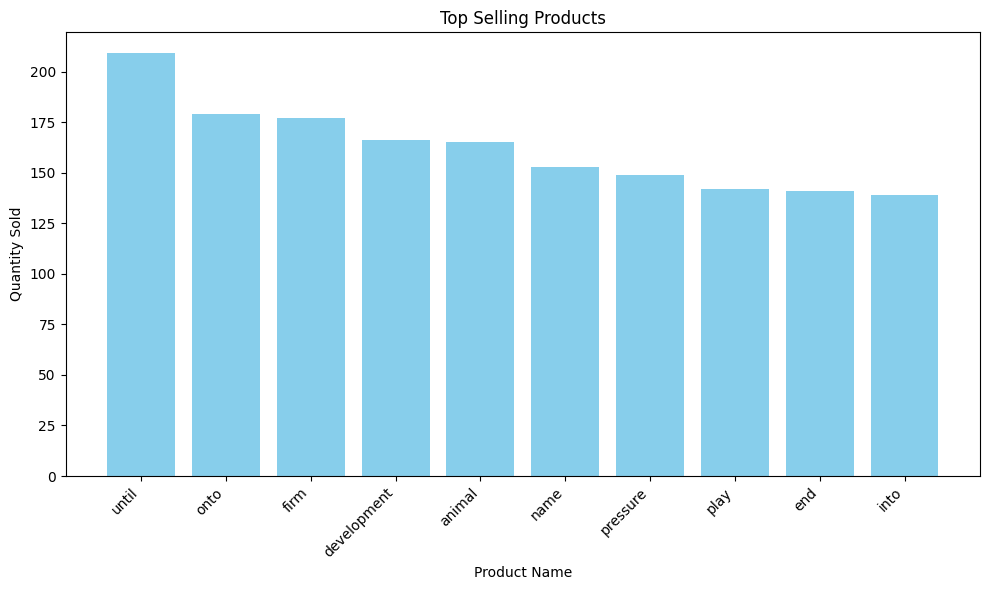

2024-11-01 10:02:09,600 - INFO - Successfully completed the plotting of top selling products.


In [30]:
get_top_selling_products(df_order_item=order_item, df_product=product, product_id_col="product_id", product_name_col="product_name", quantity_col="quantity", top_n=10)

### Top N product purchase by age groups

In [31]:
from Data_Visualization.visualization import get_top_products_by_age_group

2024-11-01 10:02:09,622 - INFO - Calculating customer age and creating age groups.
2024-11-01 10:02:09,657 - INFO - Joining customer, order, and order item DataFrames.
2024-11-01 10:02:09,678 - INFO - Aggregating product purchases by age group and product.
2024-11-01 10:02:09,698 - INFO - Retrieving the top 5 products for each age group.
2024-11-01 10:02:09,735 - INFO - Joining with product names for top products.
2024-11-01 10:02:09,742 - INFO - Collecting data for plotting.
2024-11-01 10:02:10,498 - INFO - Plotting the top 5 products by age group.


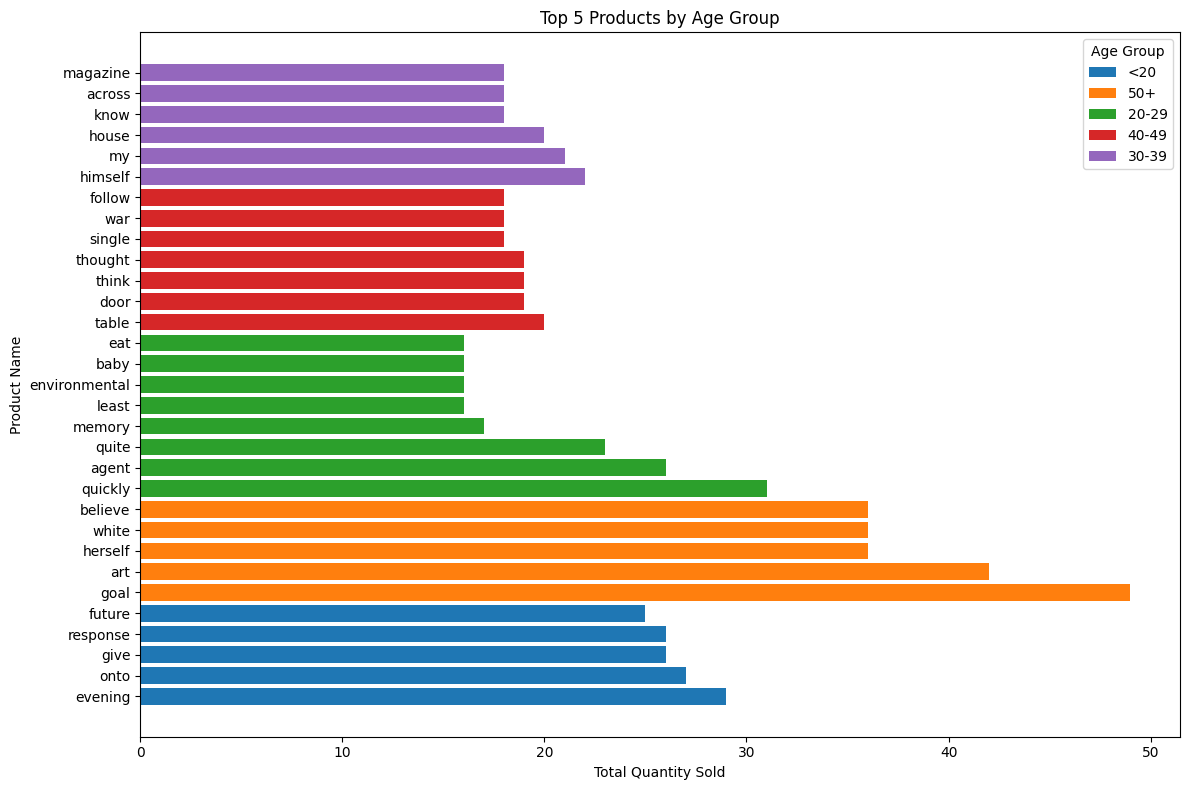

2024-11-01 10:02:10,726 - INFO - Successfully completed the top 5 products by age group plotting.


In [32]:
get_top_products_by_age_group(df_customer=customer, df_order=orders, df_order_items=order_item, df_product=product, customer_id_col="customer_id", product_id_col="product_id", order_id_col="order_id", quantity_col="quantity", product_name_col="product_name", age_col="age", top_n=5)

### Top 10 Highest Revenue Generating Products

In [33]:
from Data_Visualization.visualization import  get_top_revenue_generating_products

2024-11-01 10:02:10,753 - INFO - Joining order items and product DataFrames.
2024-11-01 10:02:10,778 - INFO - Calculating revenue for each product.
2024-11-01 10:02:10,787 - INFO - Aggregating total revenue by product name.
2024-11-01 10:02:10,803 - INFO - Sorting products by total revenue and selecting the top 10.
2024-11-01 10:02:10,812 - INFO - Collecting the top products by revenue data.
2024-11-01 10:02:11,125 - INFO - Plotting the top revenue-generating products.


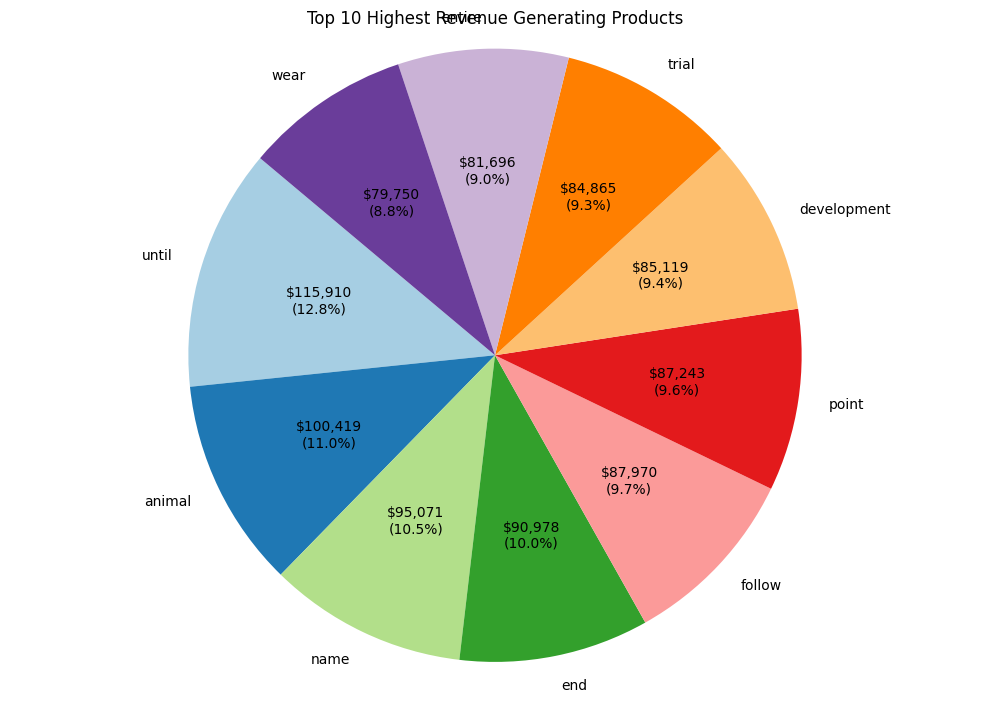

2024-11-01 10:02:11,238 - INFO - Successfully completed the top 10 highest revenue-generating products plotting.


In [34]:
get_top_revenue_generating_products(df_order_items=order_item, df_product=product, product_id_col="product_id", quantity_col="quantity", price_col="price", product_name_col="product_name", top_n=10)

### Top N Frequent ordered products

In [35]:
from Data_Visualization.visualization import  get_frequently_ordered_products

2024-11-01 10:02:11,266 - INFO - Starting the process to calculate the most frequently ordered products.
2024-11-01 10:02:11,268 - INFO - Joining order items and product DataFrames.
2024-11-01 10:02:11,298 - INFO - Aggregating the number of times each product was ordered.
2024-11-01 10:02:11,319 - INFO - Sorting products by order count and selecting the top 10.
2024-11-01 10:02:11,328 - INFO - Collecting the top frequently ordered products data.
2024-11-01 10:02:11,596 - INFO - Plotting the top frequently ordered products.


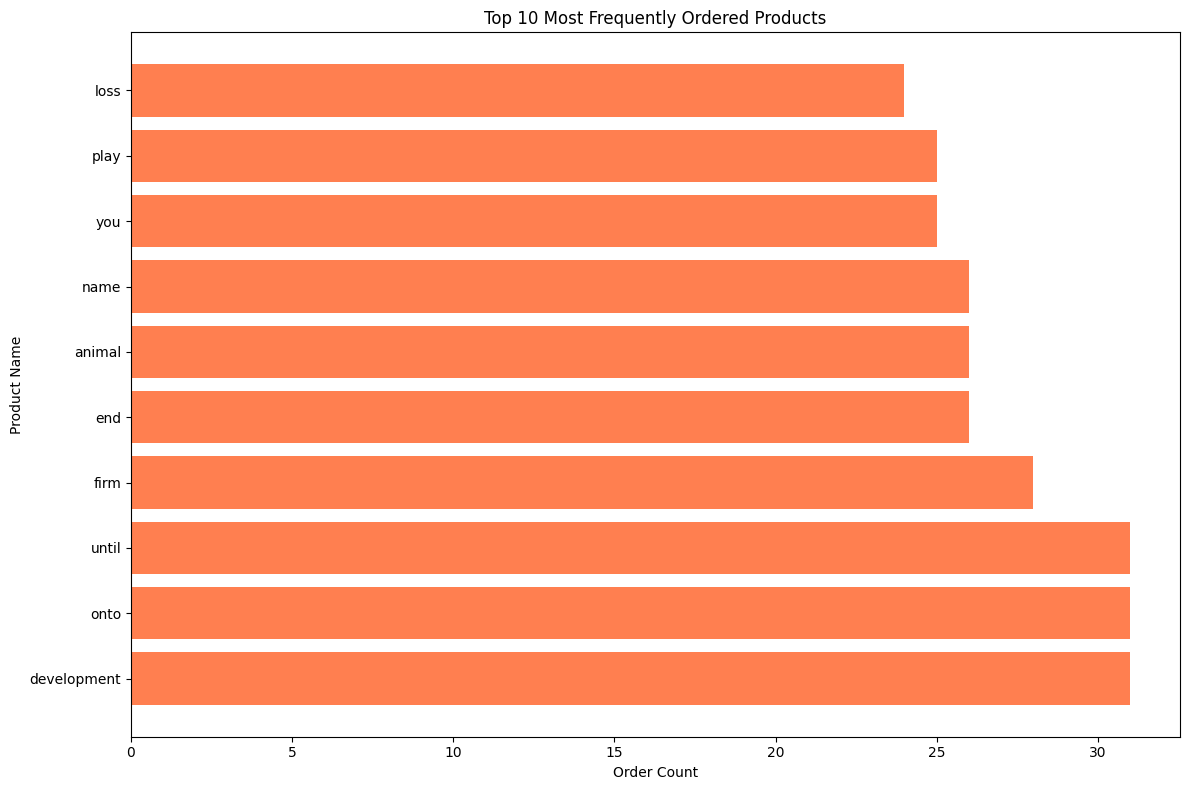

2024-11-01 10:02:11,773 - INFO - Successfully completed the top 10 frequently ordered products plotting.


In [36]:
get_frequently_ordered_products(df_order_items=order_item, df_product=product, product_id_col="product_id", product_name_col="product_name", top_n=10)

### Top N Frequently Ordered Product by Year

In [37]:
from Data_Visualization.visualization import get_frequently_ordered_products_by_year

2024-11-01 10:02:11,795 - INFO - Starting the process to calculate the most frequently ordered products for the year 2023.
2024-11-01 10:02:11,798 - INFO - Filtering orders for the year 2023.
2024-11-01 10:02:11,811 - INFO - Joining filtered orders, order items, and product DataFrames.
2024-11-01 10:02:11,830 - INFO - Aggregating the number of times each product was ordered.
2024-11-01 10:02:11,845 - INFO - Sorting products by order count and selecting the top 10.
2024-11-01 10:02:11,852 - INFO - Collecting the top frequently ordered products data.
2024-11-01 10:02:12,185 - INFO - Plotting the top frequently ordered products for the year.


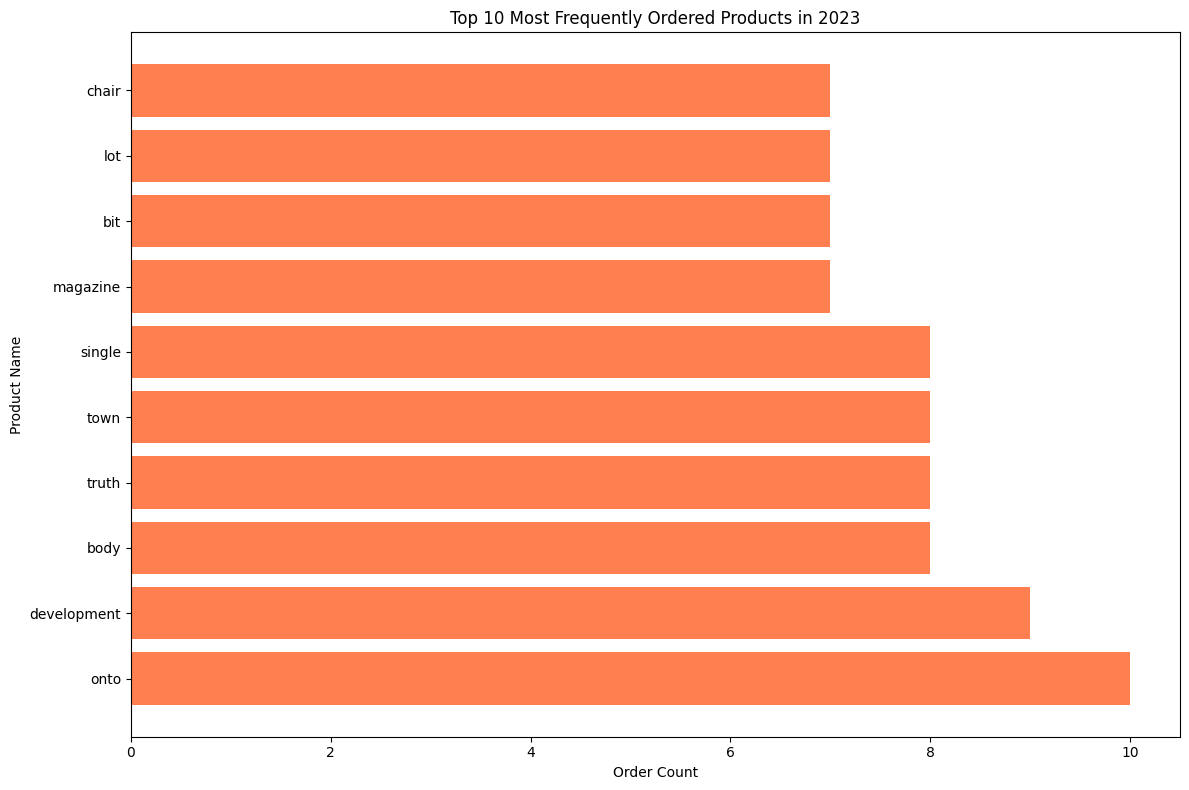

2024-11-01 10:02:12,318 - INFO - Successfully completed the top 10 frequently ordered products for the year 2023.


In [38]:
get_frequently_ordered_products_by_year(df_order_items=order_item, df_product=product, df_order=orders, order_id_col="order_id", product_id_col="product_id", product_name_col="product_name", order_date_col="order_date", year_filter=2023, top_n=10)

### Frequently Ordered Product by Age Category Group 

In [39]:
from Data_Visualization.visualization import get_frequently_ordered_products_by_age_group

2024-11-01 10:02:12,340 - INFO - Starting the process to calculate the most frequently ordered products by customer age group.
2024-11-01 10:02:12,343 - INFO - Calculating customer age and creating age groups.
2024-11-01 10:02:12,384 - INFO - Joining customers, orders, order items, and products DataFrames.
2024-11-01 10:02:12,417 - INFO - Aggregating order counts by age group and product.
2024-11-01 10:02:12,441 - INFO - Finding the top 2 products for each age group.
2024-11-01 10:02:12,469 - INFO - Collecting the top products data for each age group.
2024-11-01 10:02:12,965 - INFO - Preparing data for plotting.


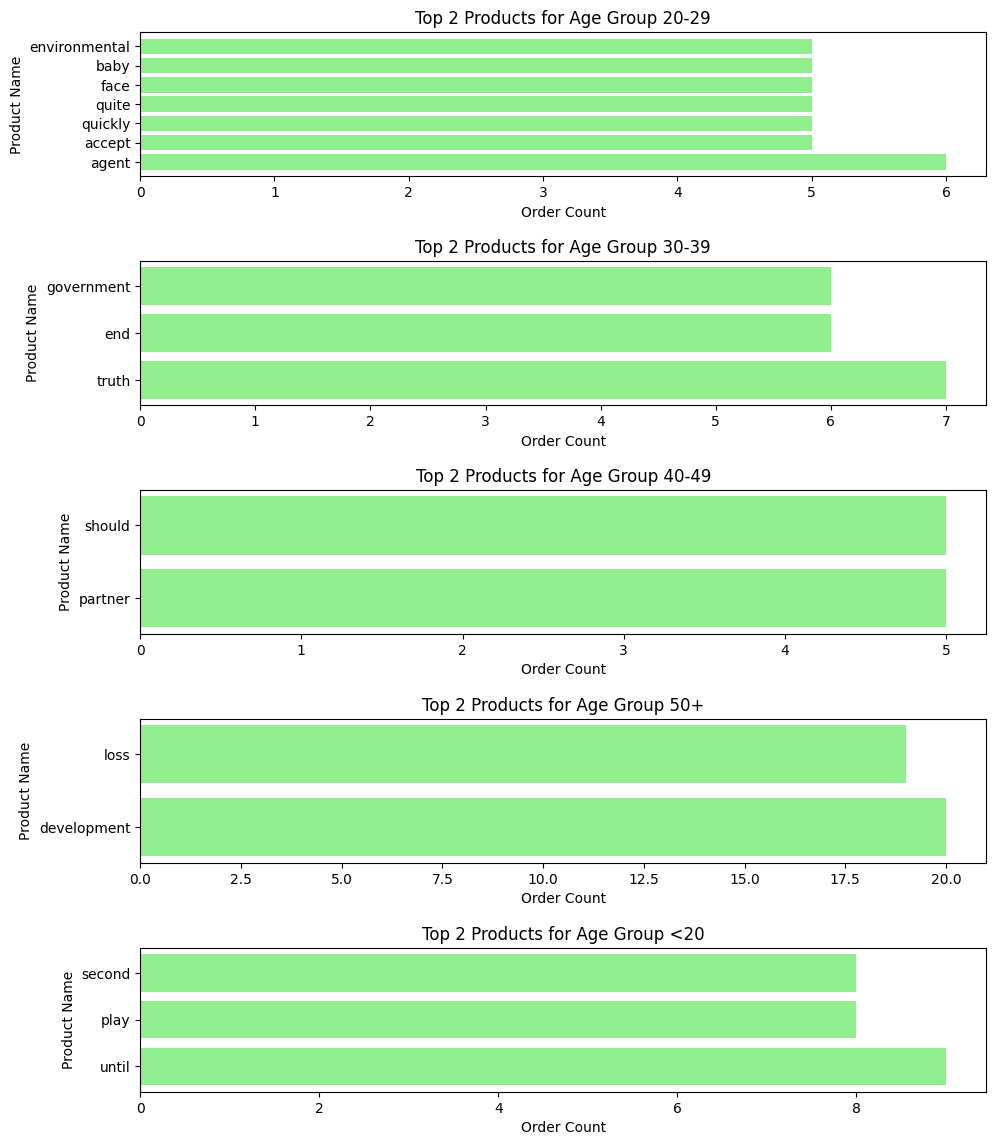

2024-11-01 10:02:13,316 - INFO - Successfully plotted the top products by age group.


In [40]:
get_frequently_ordered_products_by_age_group(df_order_items=order_item, df_product=product, df_order=orders,df_customer=customer , order_id_col="order_id", product_id_col="product_id", product_name_col="product_name", customer_id_col="customer_id" ,order_date_col="order_date", birth_date_col="birth_date", top_n=2 )

### Get Average Revenue by product category

In [41]:
from Data_Visualization.visualization import get_average_revenue_by_category

In [42]:
df_get_average_revenue_by_category = get_average_revenue_by_category(df_order_items=order_item, df_product=product, product_id_col="product_id", quantity_col="quantity", price_col="price", category_col="category")

2024-11-01 10:02:13,340 - INFO - Starting the process to calculate average revenue by product category.
2024-11-01 10:02:13,341 - INFO - Renaming price column in order items to avoid ambiguity.
2024-11-01 10:02:13,347 - INFO - Joining order items with products to calculate revenue.
2024-11-01 10:02:13,362 - INFO - Calculating revenue for each product (order_price * quantity).
2024-11-01 10:02:13,372 - INFO - Grouping by product category and calculating average revenue.
2024-11-01 10:02:13,390 - INFO - Successfully calculated average revenue by category. Returning the DataFrame.


In [43]:
df_get_average_revenue_by_category.show()

+----------+---------------+
|  category|average_revenue|
+----------+---------------+
|       few|            234|
|      hope|            337|
|      some|            511|
| recognize|            345|
|    travel|            411|
|     those|            209|
|       art|            203|
|     still|            315|
|television|            251|
| operation|            240|
|     staff|            373|
|  positive|            316|
|   include|            229|
|     often|            230|
|     watch|            217|
|   explain|            150|
|    growth|            284|
| character|            341|
|      film|            273|
|   prevent|            355|
+----------+---------------+
only showing top 20 rows



### Top N average revenue products

In [44]:
from Data_Visualization.visualization import plot_top_n_average_revenue

2024-11-01 10:02:13,750 - INFO - Starting the plotting process for top 10 categories by average revenue.
2024-11-01 10:02:13,776 - INFO - Sorting the DataFrame by average_revenue and selecting the top 10.
2024-11-01 10:02:13,792 - INFO - Collecting the data for plotting.
2024-11-01 10:02:14,051 - INFO - Plotting the top categories by average revenue.


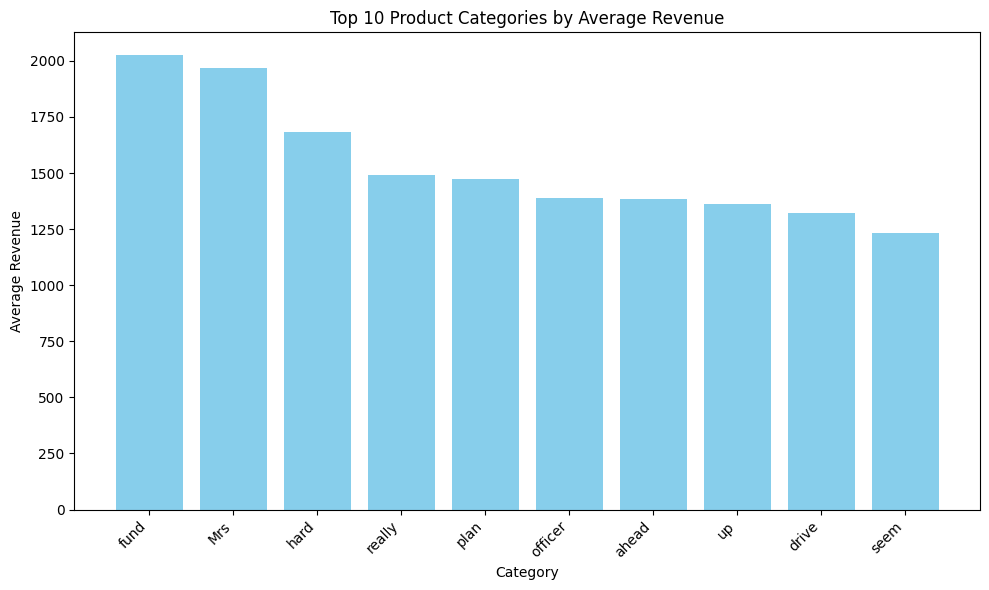

2024-11-01 10:02:14,175 - INFO - Successfully completed plotting.


In [45]:
plot_top_n_average_revenue(df_get_average_revenue_by_category, category_col="category", revenue_col="average_revenue", top_n=10)

### Total Revenue by product

In [46]:
from Data_Visualization.visualization import get_total_revenue_by_product

In [47]:
df_get_total_revenue_by_product = get_total_revenue_by_product(df_order_items=order_item, df_products=product, product_id_col="product_id", quantity_col="quantity", price_col="price", product_name_col="product_name")

2024-11-01 10:02:14,198 - INFO - Starting the process to calculate total revenue by product.
2024-11-01 10:02:14,205 - INFO - Joining order_items with products to get product names.
2024-11-01 10:02:14,213 - INFO - Calculating revenue for each product.
2024-11-01 10:02:14,224 - INFO - Grouping by product_id and product_name to calculate total revenue.
2024-11-01 10:02:14,239 - INFO - Successfully calculated total revenue by product.


In [48]:
df_get_total_revenue_by_product.show()

+----------+------------+-------------+
|product_id|product_name|total_revenue|
+----------+------------+-------------+
|      3764|     nothing|       2318.0|
|      3506|      chance|       7740.0|
|      4894|        sell|      11270.0|
|        26|      expert|       2288.0|
|      1950|     pattern|      11628.0|
|      2509|        bank|       5712.0|
|      2529|       young|       8870.0|
|       964|     morning|       9520.0|
|      1697|          TV|       1920.0|
|      2040|     soldier|       2991.0|
|        29|        stay|      16092.0|
|      1806|      travel|       4340.0|
|      4590| significant|       4060.0|
|       474|         Mrs|        397.0|
|      2453|       voice|      12096.0|
|      2927|     network|       2450.0|
|      1677|       truth|       3800.0|
|      2214|     project|        318.0|
|      2250|        only|       2645.0|
|      1224|         guy|       6966.0|
+----------+------------+-------------+
only showing top 20 rows



### Get Inventory Status

In [49]:
from Data_Visualization.visualization import get_inventory_status

In [50]:
df_inventory_status = get_inventory_status(df_order_items=order_item, df_products=product, product_id_col="product_id", product_name_col="product_name", quantity_col="quantity", price_col="price", inventory_col="inventory")


2024-11-01 10:02:14,474 - INFO - Starting the process to determine inventory status by product.
2024-11-01 10:02:14,476 - INFO - Calling get_total_revenue_by_product to get revenue data.
2024-11-01 10:02:14,479 - INFO - Starting the process to calculate total revenue by product.
2024-11-01 10:02:14,485 - INFO - Joining order_items with products to get product names.
2024-11-01 10:02:14,493 - INFO - Calculating revenue for each product.
2024-11-01 10:02:14,505 - INFO - Grouping by product_id and product_name to calculate total revenue.
2024-11-01 10:02:14,526 - INFO - Successfully calculated total revenue by product.
2024-11-01 10:02:14,531 - INFO - Joining total revenue with products to get inventory and determine status.
2024-11-01 10:02:14,543 - INFO - Assigning inventory status based on revenue and inventory conditions.
2024-11-01 10:02:14,575 - INFO - Successfully determined inventory status for each product.


In [51]:
df_inventory_status.show()

+----------+------------+---------+-------------+----------------+
|product_id|product_name|inventory|total_revenue|inventory_status|
+----------+------------+---------+-------------+----------------+
|        26|      expert|       92|       2288.0|        In stock|
|        29|        stay|      440|      16092.0|        In stock|
|      1677|       truth|      964|       3800.0|        In stock|
|      1697|          TV|      610|       1920.0|        In stock|
|      1950|     pattern|      847|      11628.0|        In stock|
|      2040|     soldier|      585|       2991.0|        In stock|
|      2214|     project|      982|        318.0|        In stock|
|      2250|        only|      755|       2645.0|        In stock|
|      2509|        bank|      413|       5712.0|        In stock|
|      2529|       young|      693|       8870.0|        In stock|
|      2927|     network|      408|       2450.0|        In stock|
|       964|     morning|       62|       9520.0|        In st

### Inventory Status

In [52]:
from Data_Visualization.visualization import plot_inventory_status_percentage

2024-11-01 10:02:14,894 - INFO - Starting the process to get inventory status and plot it.
2024-11-01 10:02:14,896 - INFO - Calling get_inventory_status to retrieve inventory status for each product.
2024-11-01 10:02:14,898 - INFO - Starting the process to determine inventory status by product.
2024-11-01 10:02:14,900 - INFO - Calling get_total_revenue_by_product to get revenue data.
2024-11-01 10:02:14,901 - INFO - Starting the process to calculate total revenue by product.
2024-11-01 10:02:14,909 - INFO - Joining order_items with products to get product names.
2024-11-01 10:02:14,916 - INFO - Calculating revenue for each product.
2024-11-01 10:02:14,928 - INFO - Grouping by product_id and product_name to calculate total revenue.
2024-11-01 10:02:14,942 - INFO - Successfully calculated total revenue by product.
2024-11-01 10:02:14,946 - INFO - Joining total revenue with products to get inventory and determine status.
2024-11-01 10:02:14,954 - INFO - Assigning inventory status based on

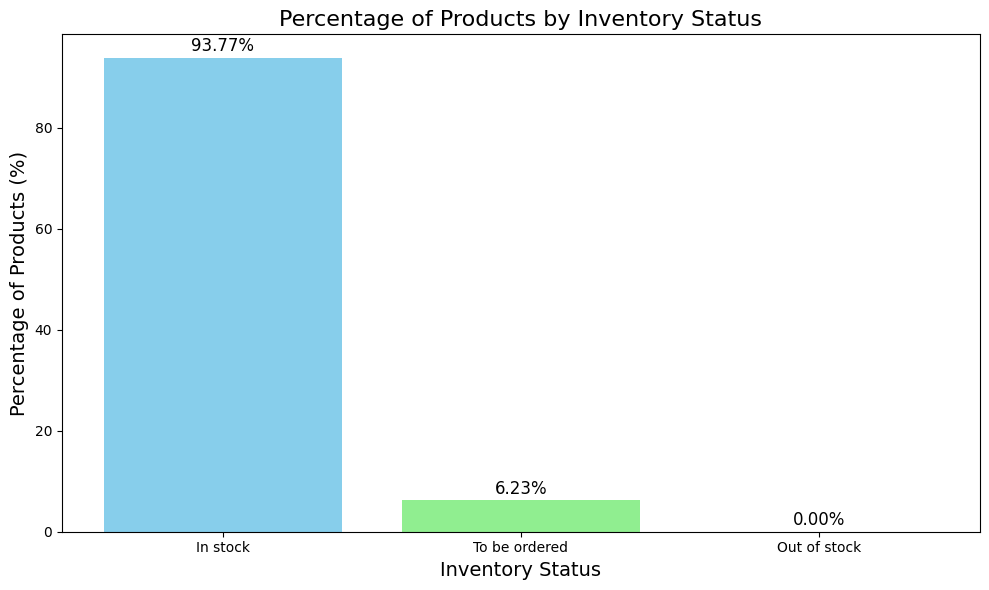

2024-11-01 10:02:15,422 - INFO - Successfully completed plotting.


In [53]:
plot_inventory_status_percentage(df_order_items=order_item, df_products=product, product_id_col="product_id", product_name_col="product_name", quantity_col="quantity", price_col="price", inventory_col="inventory")

### CLV

In [54]:
from Data_Visualization.visualization import calculate_customer_lifetime_value

In [55]:
df_calculate_customer_lifetime_value = calculate_customer_lifetime_value(df_order_items=order_item, df_orders=orders, df_customers=customer, order_id_col="order_id", customer_id_col="customer_id", price_col="price", quantity_col="quantity", first_name_col="first_name", last_name_col="last_name")

2024-11-01 10:02:15,442 - INFO - Starting the process to calculate CLV for each customer.
2024-11-01 10:02:15,452 - INFO - Joining order_items with orders to get customer_id.
2024-11-01 10:02:15,460 - INFO - Calculating revenue for each order item.
2024-11-01 10:02:15,467 - INFO - Grouping by customer_id and calculating total revenue (CLV).
2024-11-01 10:02:15,491 - INFO - Joining CLV DataFrame with customers to get customer names.
2024-11-01 10:02:15,502 - INFO - Successfully calculated CLV and joined with customer names.


In [56]:
df_calculate_customer_lifetime_value.show()

+-----------+------------------+----+
|customer_id|     customer_name| CLV|
+-----------+------------------+----+
|         29|   Samantha Murphy|1023|
|       3091|   Heather Manning|1849|
|        964|    Michelle Leach|1539|
|       4823|     Vickie Harris| 430|
|       3506|     Kevin Johnson|9315|
|       2040|Lindsey Fitzgerald|1464|
|       1677|        Lynn Avila| 634|
|       2453|   James Mcpherson| 594|
|       2927|  Douglas Gonzalez|3008|
|       3764|      Jessica Long| 588|
|       4894|     Penny Fleming| 243|
|       2941|   Joseph Chambers|1363|
|       3800|         Leslie Yu| 767|
|       3061|      Blake Vaughn|2383|
|       4126|      Matthew Huff| 957|
|        558|     David Hopkins| 330|
|        191|   Michael Camacho|1211|
|       3199|  Douglas Gonzalez| 282|
|       1360|    Olivia Barrett| 229|
|       3009|    Richard Daniel|3502|
+-----------+------------------+----+
only showing top 20 rows



In [57]:
from Data_Visualization.visualization import plot_top_n_premium_customers

2024-11-01 10:02:15,848 - INFO - Starting the plotting process for top 10 premium customers based on CLV.
2024-11-01 10:02:15,851 - INFO - Sorting the DataFrame by CLV and selecting the top 10 customers.
2024-11-01 10:02:15,864 - INFO - Collecting the data for plotting.
2024-11-01 10:02:16,166 - INFO - Plotting the top premium customers by CLV.


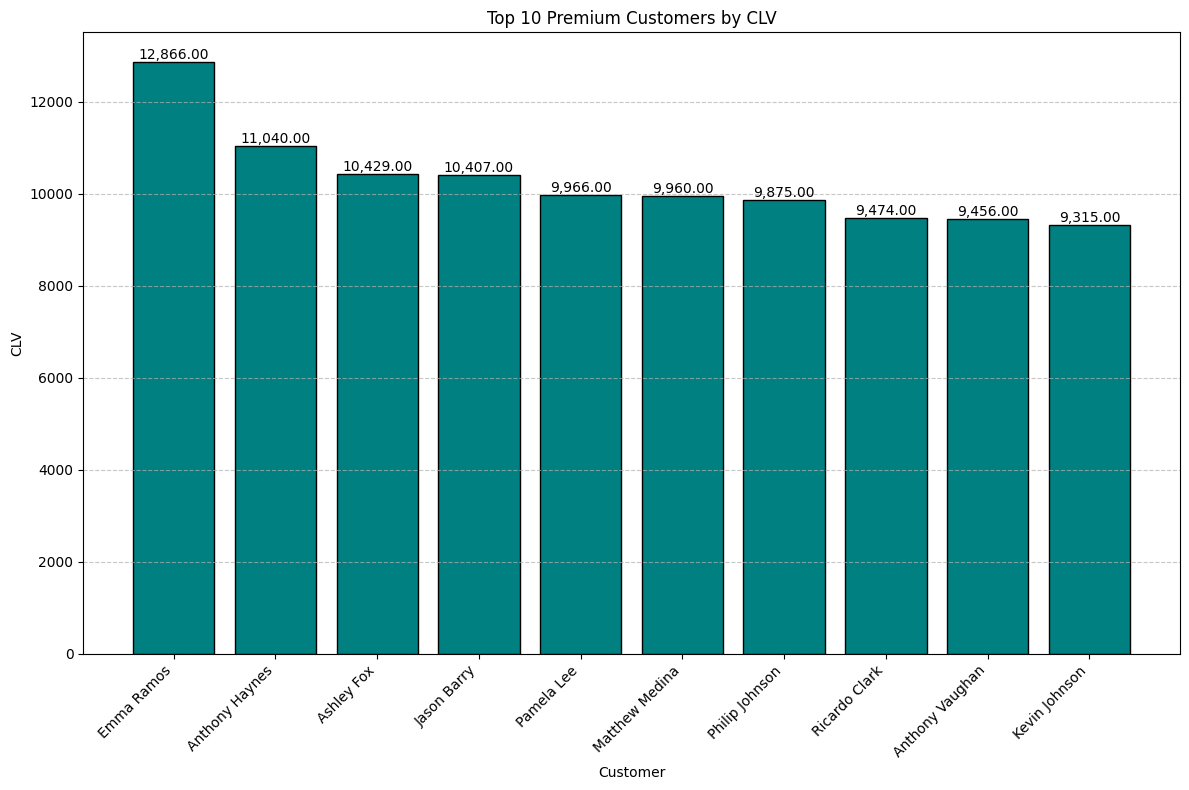

2024-11-01 10:02:16,361 - INFO - Successfully completed plotting.


In [58]:
plot_top_n_premium_customers(df_customer_clv=df_calculate_customer_lifetime_value, customer_name_col="customer_name", clv_col="CLV", top_n=10)

### Yearly Revenue

In [59]:
from Data_Visualization.visualization import calculate_yearly_revenue

In [60]:
df_calculate_yearly_revenue = calculate_yearly_revenue(df_orders=orders, df_order_items=order_item, order_id_col="order_id", order_date_col="order_date", price_col="price", quantity_col="quantity")

2024-11-01 10:02:16,386 - INFO - Starting the calculation of yearly revenue.
2024-11-01 10:02:16,388 - INFO - Calculating revenue for each order item.
2024-11-01 10:02:16,402 - INFO - Joining order items with orders to get the order_date.
2024-11-01 10:02:16,411 - INFO - Extracting the year from the order_date.
2024-11-01 10:02:16,419 - INFO - Aggregating total revenue by year.
2024-11-01 10:02:16,434 - INFO - Successfully calculated yearly revenue.


In [61]:
df_calculate_yearly_revenue.show()

+----+-------------+
|year|total_revenue|
+----+-------------+
|2025|        84088|
|2023|       621244|
|2022|       686147|
|2019|       229329|
|2020|       601361|
|2024|       435985|
|2021|       631219|
+----+-------------+



In [62]:
from Data_Visualization.visualization import plot_yearly_revenue

2024-11-01 10:02:16,817 - INFO - Starting the plotting process for yearly revenue.


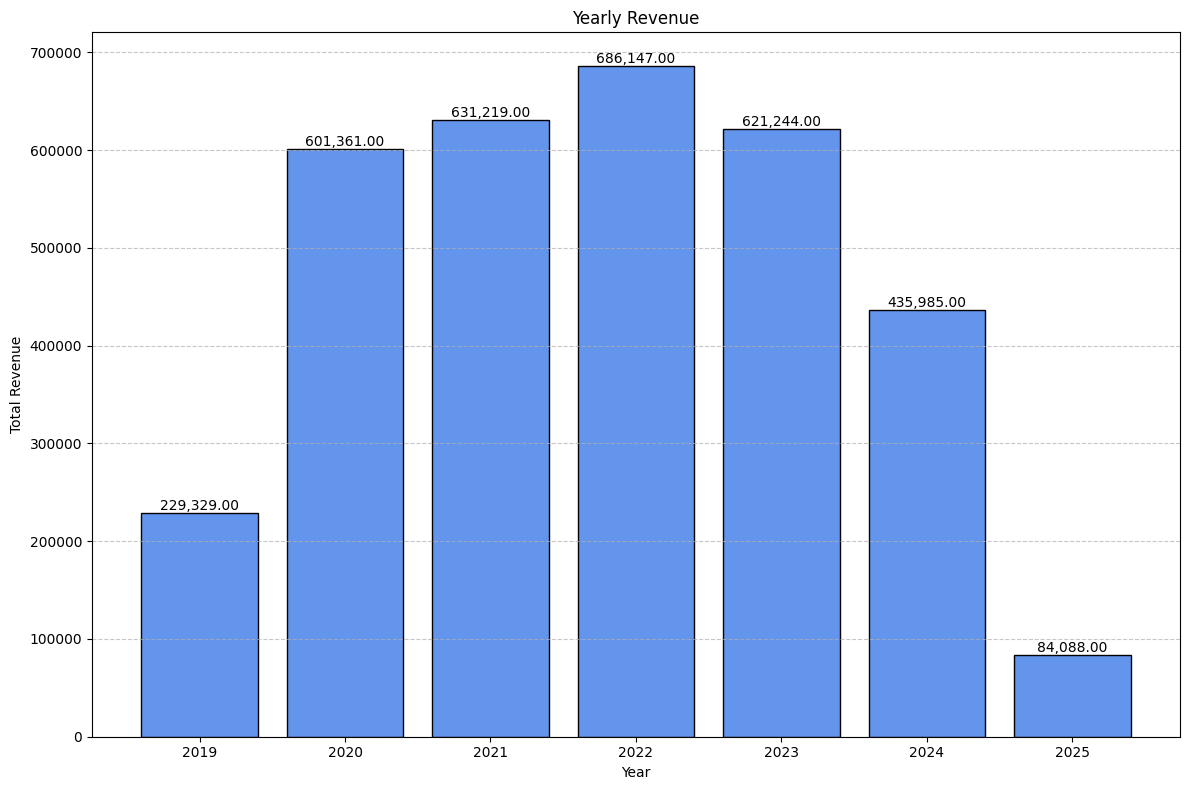

2024-11-01 10:02:17,228 - INFO - Successfully completed plotting yearly revenue.


In [63]:
plot_yearly_revenue(df_yearly_revenue=df_calculate_yearly_revenue, year_col="year", total_revenue_col="total_revenue")

### Get Max Order per year

In [64]:
from Data_Visualization.visualization import get_max_orders_per_year


In [65]:
df_get_max_orders_per_year = get_max_orders_per_year(df_orders=orders, order_date_col="order_date", order_id_col="order_id")

2024-11-01 10:02:17,249 - INFO - Starting the process to calculate maximum orders per year.
2024-11-01 10:02:17,251 - INFO - Extracting year from the order_date column.
2024-11-01 10:02:17,261 - INFO - Counting the number of orders per year.
2024-11-01 10:02:17,275 - INFO - Finding the maximum number of orders per year.
2024-11-01 10:02:17,286 - INFO - Successfully calculated maximum orders per year.


In [66]:
df_get_max_orders_per_year.show()

+----+----------+
|year|max_orders|
+----+----------+
|2025|       121|
|2023|       943|
|2022|       970|
|2019|       329|
|2020|       978|
|2024|       701|
|2021|       958|
+----+----------+



In [67]:
from Data_Visualization.visualization import plot_max_orders_per_year

2024-11-01 10:02:17,483 - INFO - Starting the plotting process for maximum orders per year.
2024-11-01 10:02:17,485 - INFO - Collecting the data for plotting.
2024-11-01 10:02:17,661 - INFO - Plotting the maximum orders per year.


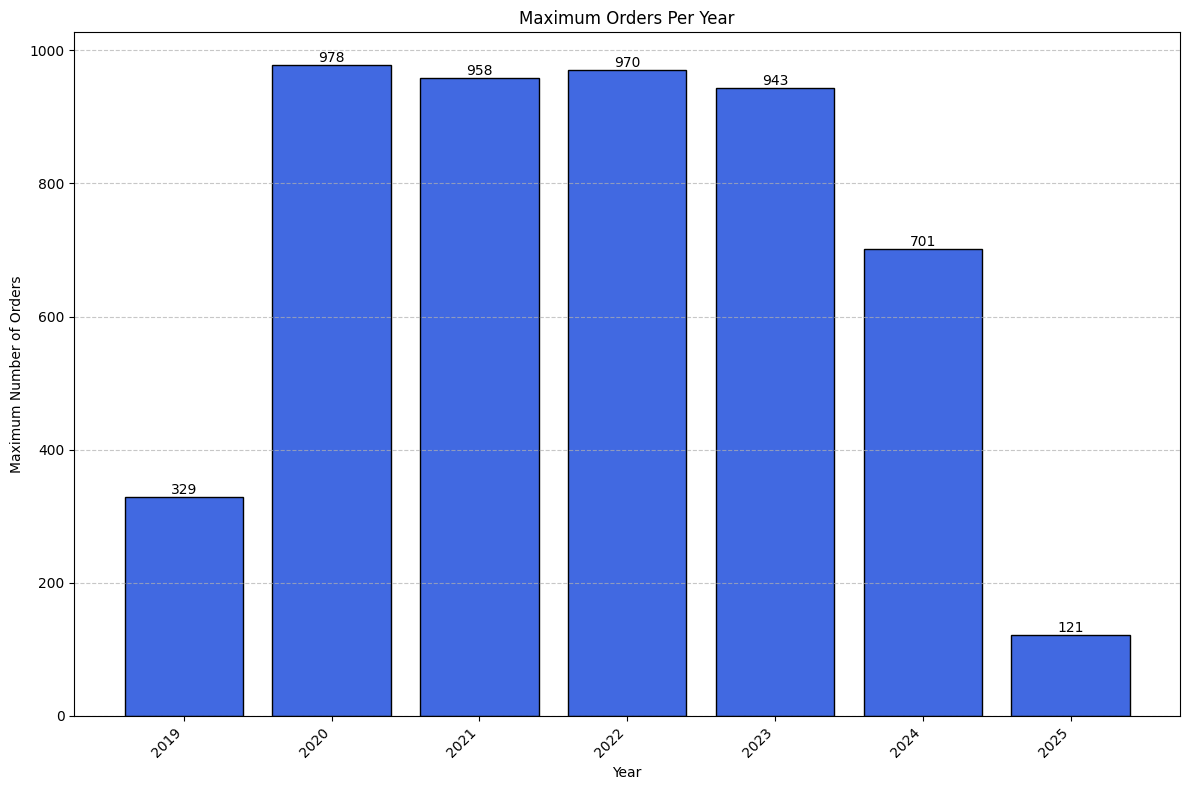

2024-11-01 10:02:17,806 - INFO - Successfully completed plotting.


In [68]:
plot_max_orders_per_year(df_max_orders=df_get_max_orders_per_year, year_col="year", max_orders_col="max_orders")

### Categorize_Reviews

In [69]:
from Data_Visualization.visualization import categorize_reviews

In [70]:
df_categorize_review = categorize_reviews(df_reviews=review, df_products=product, rating_col="rating", product_id_col="product_id", product_name_col="product_name")

In [71]:
df_categorize_review.show()

+----------+------------+--------------+----------------+
|product_id|product_name|average_rating| rating_category|
+----------+------------+--------------+----------------+
|        29|        stay|             4|highly-satisfied|
|      2509|        bank|             3|    satisfactory|
|      2927|     network|             4|highly-satisfied|
|      3091|         arm|             3|    satisfactory|
|       474|         Mrs|             3|    satisfactory|
|      2214|     project|             3|    satisfactory|
|      4894|        sell|             5|       excellent|
|      2453|       voice|             2|         average|
|      1950|     pattern|             3|    satisfactory|
|      1677|       truth|             2|         average|
|      2040|     soldier|             2|         average|
|      4823|     example|             5|       excellent|
|      2529|       young|             1|            poor|
|      1806|      travel|             5|       excellent|
|        26|  

In [72]:
from Data_Visualization.visualization import plot_top_n_product_ratings

2024-11-01 10:02:18,160 - INFO - Starting the plotting process for top 10 products with highest average ratings.
2024-11-01 10:02:18,164 - INFO - Sorting the DataFrame by average_rating and selecting the top 10.
2024-11-01 10:02:18,187 - INFO - Collecting data from DataFrame.
2024-11-01 10:02:18,392 - INFO - Extracted product names, ratings, and categories.
2024-11-01 10:02:18,436 - INFO - Plotting top 10 products with highest average ratings.


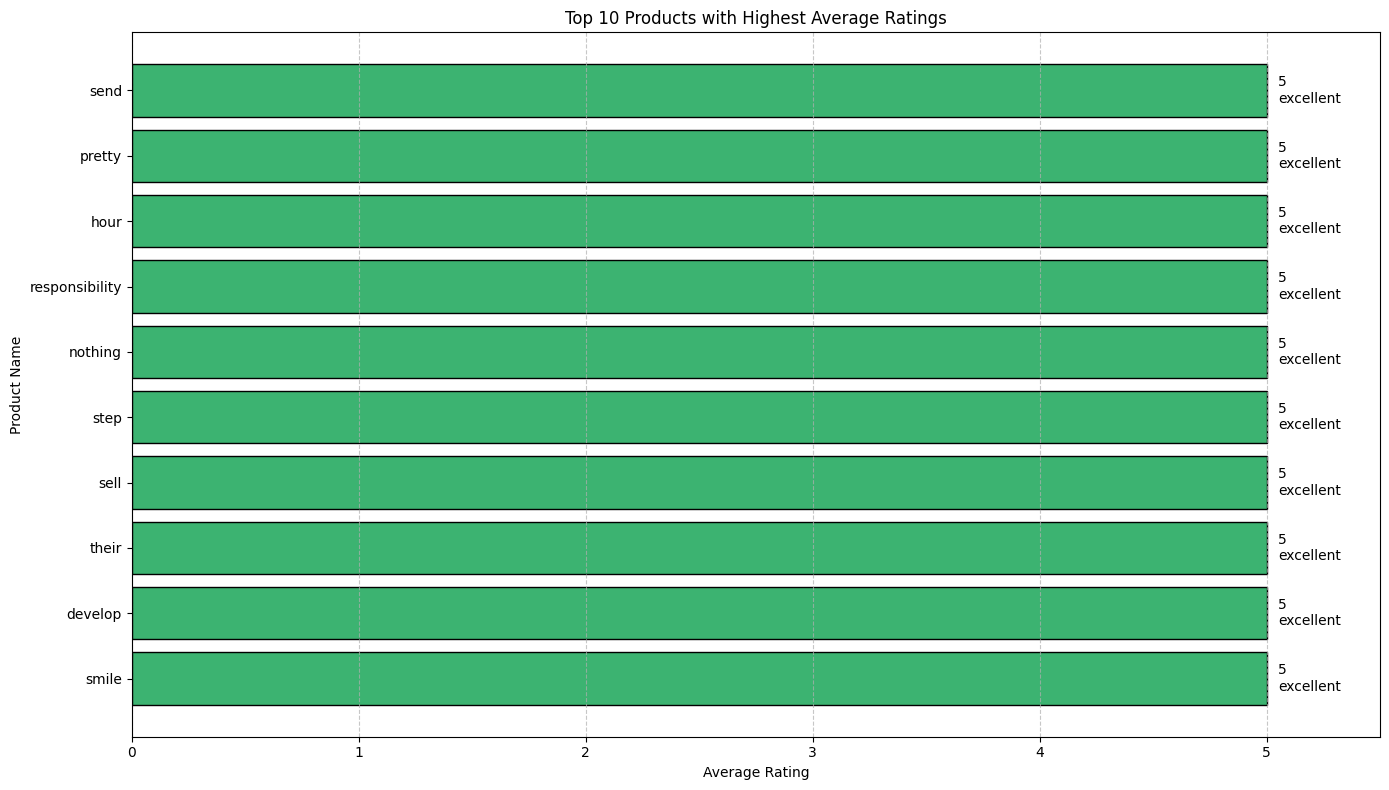

2024-11-01 10:02:18,556 - INFO - Plot displayed successfully.


In [73]:
plot_top_n_product_ratings(df_categorize_reviews = df_categorize_review, product_id_col="product_id", product_name_col="product_name", average_rating_col="average_rating", rating_category_col="rating_category", top_n=10)

### Top Products Trend Monthly 

In [74]:
from Data_Visualization.visualization import plot_top_product_yearly_trends

2024-11-01 10:02:18,583 - INFO - Starting the process to plot yearly trends for top products.
2024-11-01 10:02:18,661 - INFO - Collecting data for plotting.
2024-11-01 10:02:19,341 - INFO - Data collection complete. 33 rows collected.
2024-11-01 10:02:19,342 - INFO - Preparing data for plotting.
2024-11-01 10:02:19,343 - INFO - Data prepared for plotting. Years range: [2019, 2020, 2021, 2022, 2023, 2024, 2025]
2024-11-01 10:02:19,344 - INFO - Starting to plot the data.


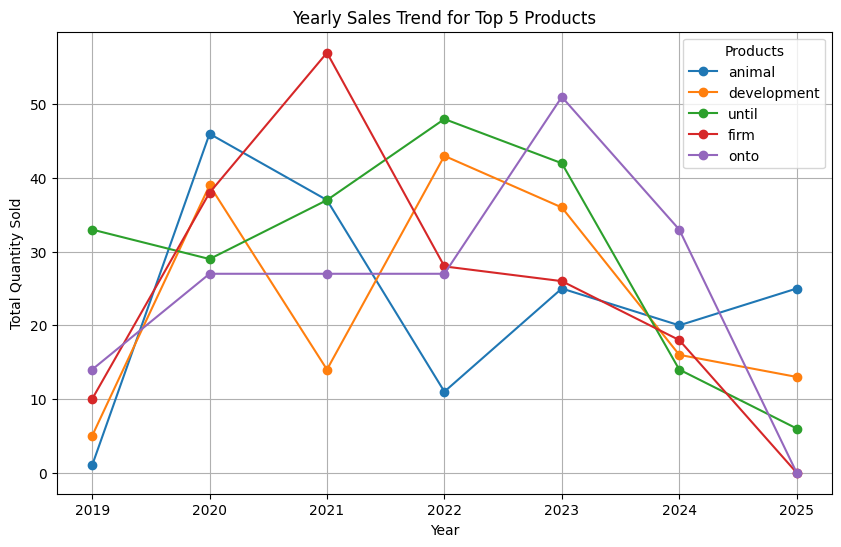

2024-11-01 10:02:19,469 - INFO - Plotting complete and displayed.


In [75]:
plot_top_product_yearly_trends(df_orders=orders, df_order_items=order_item, df_products=product, order_id_col="order_id", order_date_col="order_date", product_id_col="product_id", quantity_col="quantity", product_name_col="product_name", top_n=5)

In [76]:
from Data_Visualization.visualization import plot_top_product_monthly_trends

2024-11-01 10:02:19,561 - INFO - Finding top 10 products based on total quantity sold.
2024-11-01 10:02:19,585 - INFO - Top 10 products determined.
2024-11-01 10:02:20,262 - INFO - Collecting sales data for plotting.
2024-11-01 10:02:20,722 - INFO - Plotting monthly sales trends.


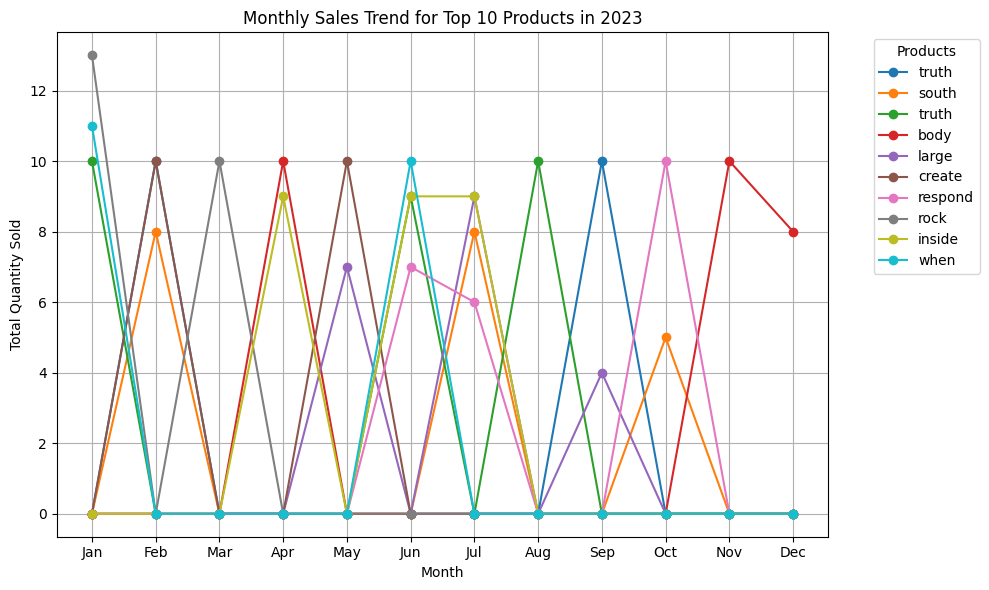

2024-11-01 10:02:20,903 - INFO - Successfully plotted monthly sales trends for the top 10 products in 2023.


In [77]:
plot_top_product_monthly_trends(spark,orders_df=orders, order_items_df=order_item, products_df=product, order_id_col='order_id', order_date_col='order_date', product_id_col='product_id', quantity_col='quantity', product_name_col='product_name', year=2023,  top_n= 10)
